# Tree-Based Models for Machine Learning

[Click here](https://neuronjolt.com/data/downloads/ch_12_tree_based_models.ipynb) to download this chapter as a Jupyter (.ipynb) file.

In this chapter we learn about two tree-based predictive algorithms for machine learning - decision trees and random forests. A decision tree uses a single tree to make predictions, and a random forest combines the predictions of many trees to make its predictions. Models based on trees may be used for both classification and regression tasks. Tree-based models have a few strong advantages. They are fairly easy to visualize and understand, at least for smallertrees, and there is no need to scale numeric data before fitting a tree-based model. They work well with data that has a mix of categorical and numeric features, but single trees tend to overfit the training data. For that reason it is common to use ensemble methods (methods based on collections, or ensembles of trees) in place of a single decision tree. The random forest model that we will learn about it this chapter is and example of an ensemble method based on decision trees.

### Module and Function Imports

In [1]:
import mglearn 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_validate

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_moons

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import export_graphviz

## Decision Trees (Single-Tree Models)

A tree is a hierarchy of if/else questions, leading to a decision. For example, consider a classification task in which we are trying to classify animals as various species depending on their characteristics, such as if they have feathers, if they can fly, and if they have fins. the decision tree shown below could be used to do the classification. We start at the top of the tree and ask questions as we go down. After each question the data is split into two directions, based on the answer to the question. Each instance in the data will end up at one leaf at the bottom row of the tree, and we can classify the species of that instance based on where it ends up at the bottom of the tree.

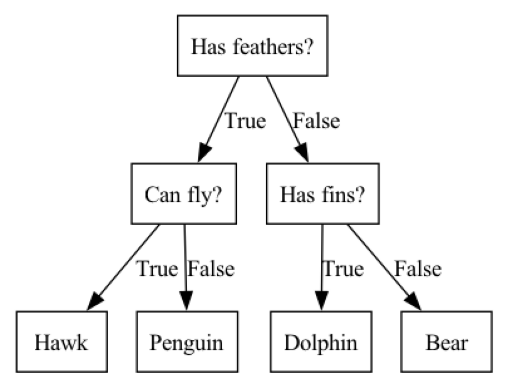

In [2]:
mglearn.plots.plot_animal_tree()

### Some tree vocabulary

Before we continue with our exploration of tree-based models we should learn some basic vocabulary related to these models. Each point in the tree at which a splitting decision could be made is called a ***node***. Nodes at the bottom of the tree are called ***leaf nodes*** or ***leaves***. The tree can be described by its ***depth***. The depth is the number of splits it takes to reach the lowest leaf node(s) from the top level

### How does the tree determine how to split at each node?

Note that there are many specific implementations of decision trees, all of which use slightly different algorithms. The explanation provided below is a generic explanation that applies to most decision tree implementations.

The goal of a decision tree is to recursively split the dataset into subsets that are as homogeneous as possible with respect to the target variable. For example, if we start with 50 instances of data in which 25 instances have the target variable value 'malignant' and 25 instances have the target variable value 'benign', a split that resulted in all the 'malignant' instances on one side of the split and all the 'benign' instances on the other side of the split would be a perfect split, because the two leaves that resulted from the split are both homogeneous with respect to the target variable. It would be very unusual to encounter such a perfect split in a real classification task, but we can use that extreme example to understand the general concept; the more homogeneous the leaves resulting from the split are the better the split is considered to be. Another term for homogeneity is purity. At each node the tree-building algorithm finds the split that results in the greatest weighted average purity of the resulting leaves. There are several different ways that purity or impurity can be measured. Two common measures of impurity are **Gini impurity** and **entropy**. You may also encounter the term **information gain** which refers to a *reduction* in entropy.

Let's take a closer look at Gini impurity. For binary classification, Gini impurity ranges from 0 to 0.5, where 0 represents pure nodes (all instances in the node belong to the same class), and 0.5 represents maximum impurity (an equal distribution of instances across all classes). It is calculated for a node as as 1 minus the sum of squared class proportions with the following formula, where $k$ is the number of classes and $p_i$ is the proportion of class $i$ in the node: $$G = 1 - \sum_{i=1}^{k} {p_i}^2$$

To find the best split at each node the tree algorithm considers all the possible splits for each feature and selects the split that maximizes the impurity reduction. This process continues recursively until a stopping criterion is met, such as reaching a maximum tree depth, having a minimum number of instances in a leaf node, or when further splits do not improve impurity beyond a minimum threshold.

The decision tree-building process is essentially a *greedy algorithm*, making locally optimal choices at each node. Note that this might not always result in the optimal tree structure at a global level. This weakness of single-tree models is another motivator for models based on ensembles of trees, which create multiple trees and then combine their predictions.

### Visualization of a Tree-Based Binary Classification Model with 2 Features

Let's take a look at some visualizations that show what happens in the first several splits of a tree-building process. We begin by visualizing the data. There are two features, and the target variable has two classes, blue circles and orange triangles. The next few visualizations show the decision boundary created by each split and the current state of the decision tree after each split. Note how adding levels to the tree allows the tree more flexibility to fit the training data. Consider how that will affect generalization performance.

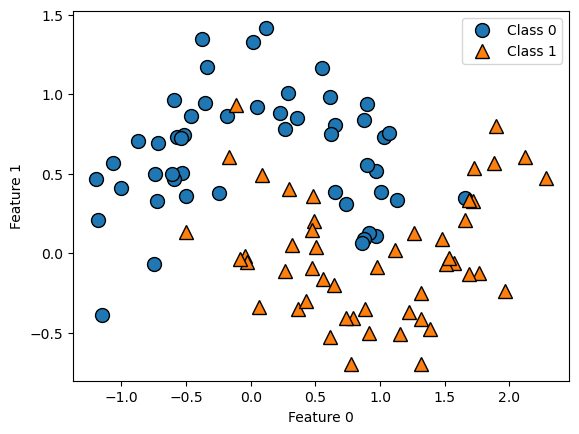

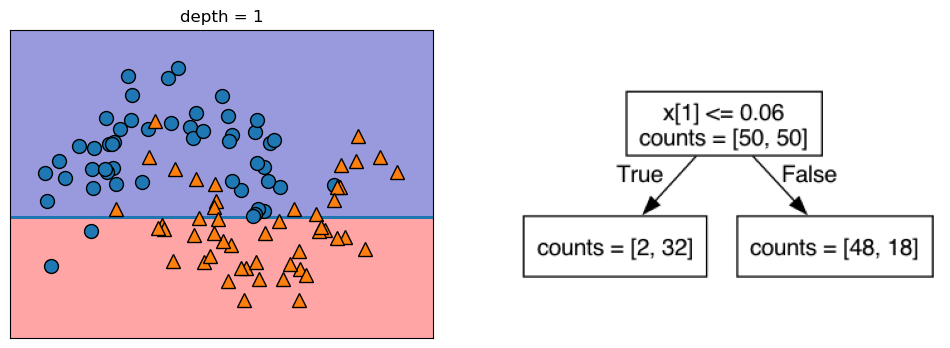

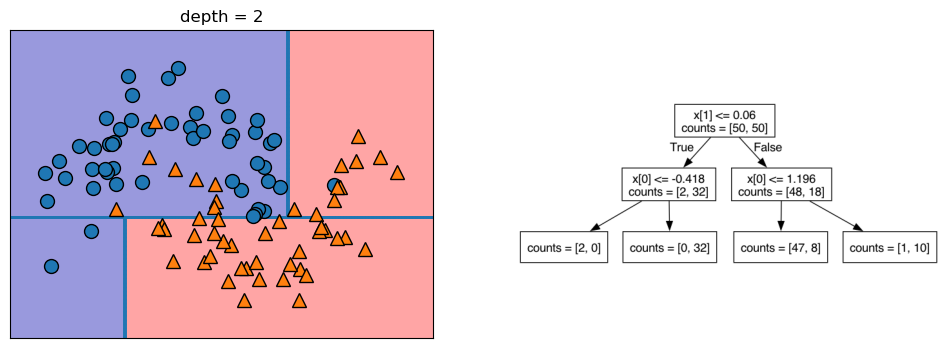

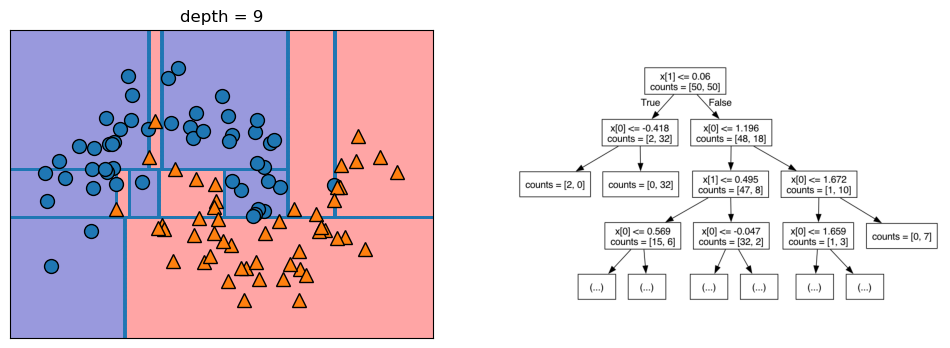

In [3]:
mglearn.plots.plot_tree_progressive()

### Controlling the Complexity of Decision Trees

If a decision tree model is permitted to continue to split leaves it attempt to keep splitting until all the leaves are pure. So, the more freedom we give the tree to continue to split leaves and grow, the more flexibility we are giving it to fit the training data. We can control the flexibility of decision trees with ***pre-pruning*** or ***post-pruning***. Pre-pruning refers to setting some parameter that causes the tree to stop growing *before* reaching the point where it can no longer improve the purity of the leaves with more splits. Following are some commonly-used pre-pruning parameters (see the scikit-learn documentation for others):
* `max_depth` - maximum number of levels for the tree
* `max_leaf_nodes` - maximum number of leaf nodes
* `min_samples_leaf` - stops the splitting when either of the leaves resulting from the split would have less than this number of instances in it. 

When we build single-tree models with scikit-learn we will vary one or more of these parameters to modify the model's flexibility to fit the training data. 

There are also approaches that utilize ***post-pruning***. With post-pruning approaches the full tree is built and then some nodes are removed or collapsed according to some criterion. We will not be covering post-pruning approaches in this chapter.

The primary purpose of both pre-pruning and post-pruning is to limit the complexity (flexibility) of the tree so that it does not overfit the training data.

## Estimate Generalization Performance for and Tune the Decision Tree model

Let's run through the **full model-building process** for the decision tree algorithm on the breast cancer data, tuning the `min_samples_leaf` parameter:

* set up a grid search
* run the grid search once to see if parameter range selected is reasonable
* run a ***nested cross validation*** to estimate generalization performance. Recall that a nested cross validation is a cross validation that uses a grid search as the estimator. It is considered the best way to estimate a model's generalization performance. Note that it cannot be used to tune the parameters of the final model, however, because each of the interior grid searches may arrive at different settings for the parameters. Because of this, a nested cross validation is typically used to select the best algorithm for the model (tree, logistic regression, K-nn, etc.) and then a separate grid search is performed on the best algorithm using all the data to set the final model parameters
* perform final grid search on all the data to tune the model

In [5]:
cancer = load_breast_cancer()
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

### Define the grid search

Since the breast cancer dataset has only numeric features and we don't need to scale the features for tree-based models, we don't need to set up a column transformer or a pipeline for this grid search. If the data did contain some categorical columns we would need to set up a column transformer to one-hot encode the categorical columns and a pipeline to combine the one-hot encoding with the tree algorithm. We set the `n_jobs` parameter to -1, which tells scikit learn to parallelize the grid search over all available processor cores.

In [6]:
gs_dt = GridSearchCV(estimator = DecisionTreeClassifier(),
                     param_grid = {'min_samples_leaf': range(1, 35)},
                     cv = 10,
                     n_jobs = -1,
                     return_train_score = True)

### Run the grid search once to check parameter range

In the initial grid search we are varying the parameter `min_samples_leaf` from 1 to 35. This parameter controls how far the tree can keep splitting, because a split will not be done if it would result in a leaf with fewer instances in it than the `min_samples_leaf` setting. The choice of 1 to 35 was arbitrary, so we are running the grid search once to see if this paramter range is appropriate. If the best `min_samples_leaf` setting turned out to be 35, for example, we would want to try a range including some numbers over 35. For the grid search we use in the nested cross validation below we want to use a parameter range centered around the best parameter setting from this initial grid search, but if the best parameter setting from the initial grid search is at the high end of the range we should extend the range and try again. 

In [7]:
gs_dt.fit(cancer.data, cancer.target)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'min_samples_leaf': range(1, 35)},
             return_train_score=True)

In [8]:
gs_dt.best_params_

{'min_samples_leaf': 10}

We used the `best_params_` property of the fitted grid search object to see what the grid search identified as the best parameter setting for `min_samples_leaf`. It found that 10 was the best parameter setting. This suggests that our range of 1 to 35 is reasonable, because the best parameter setting found on the initial grid search was near the middle of that range. We can now proceed to do the nested cross validation to estimate generalization performance for the decision tree model on the breast cancer data.

### Perform the Nested Cross Validation: Use the grid search as the estimator in a cross validation

To practice using a custom splitter, we will use 2 x stratified 10-fold cross validation. Note that we do not set the `n_jobs` parameter within the `cross_validate` function below, because it is already set in the grid search that serves as the estimator in the `cross_validate` function. It is recommended to only set the `n_jobs` parameter in one level of a nested grid search, either in the grid search or the cross validate but not both.

In [24]:
# Define the custom splitter to do 2 x stratified 10-fold cross validation
rskf_2x10 = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 2)

# Perform the nested cross validation
results_dt = cross_validate(estimator = gs_dt,
                            X = cancer.data,
                            y = cancer.target,
                            cv = rskf_2x10)

#### Calculate the mean test score as estimate of generalization performance

Below we calculate the mean score on the test folds from the nested cross validation. This is our best estimate of the generalization performance of the decision tree model on the breast cancer data. It is also useful to take a look at the standard deviation of the test score to see how sensitive the test scores are to the data splits.

In [25]:
results_dt['test_score'].mean()

0.9279448621553884

In [26]:
results_dt['test_score'].std()

0.033696226896525704

So, our estimate of the generalization performance of the decision tree model on the breast cancer data is around 93% accuracy, with a standard deviation of around 3%.

### Run a grid search with all the data for final model tuning

The final step in the model-building process is to perform a final grid search on all the data to tune the `min_samples_leaf` parameter. This time we will use 3 x stratified 10-fold cross validation. This will give us 30 splits instead of 10 splits, which should give us a more robust estimate of the best parameter setting. We set up a new grid search, called `gs_dt_2` to change the `cv` parameter. 

In [27]:
rskf_3x10 = RepeatedStratifiedKFold(n_repeats = 3, n_splits = 10)

gs_dt_2 = GridSearchCV(estimator = DecisionTreeClassifier(),
                       param_grid = {'min_samples_leaf': range(1, 35)},
                       cv = rskf_3x10,
                       n_jobs = -1,
                       return_train_score = True)

gs_dt_2.fit(cancer.data, cancer.target)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'min_samples_leaf': range(1, 35)},
             return_train_score=True)

#### Use the `best_params_` property of the `GridSearchCV` object to show the best parameter setting

In [28]:
gs_dt_2.best_params_

{'min_samples_leaf': 5}

#### Use the `best_score_` property of the `GridSearchCV` object to show the mean test fold score at the best parameter setting

In [29]:
gs_dt_2.best_score_

0.9349310776942357

You will likely see that the best mean score on the test folds in the final grid search is slightly higher than the estimate of generalization performance produced by the nested cross validation. This is because within the grid search the same data is ultimately used to both set the parameter values and test performance, so the best parameter setting is tuned specifically to the data. This produces a biased estimate of generalization performance. In a nested cross validation, by contrast, there is complete separation between the data used to tune the model and the data used to estimate its performance, so the estimate of generalization performance produced by a nested cross validation is more reliable.

## Create a Validation Curve Graph

This will help illustrate the relationship between model flexibility, controlled with the `min_samples_leaf` parameter, and model performance.

### Convert the grid search results to a DataFrame

In [30]:
results_df = pd.DataFrame(gs_dt_2.cv_results_)

### Create the validation curve graph

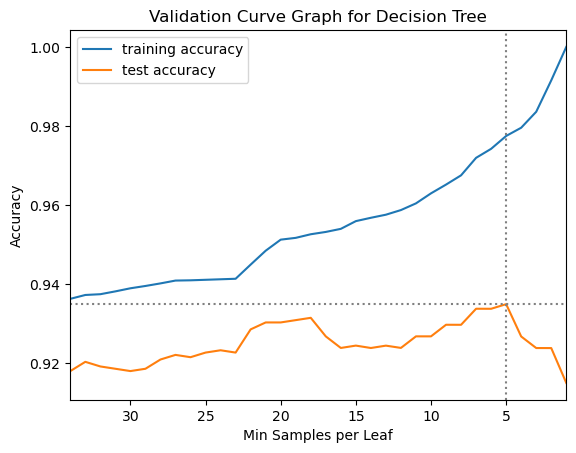

In [31]:
plt.plot(results_df.param_min_samples_leaf, 
         results_df.mean_train_score, 
         label="training accuracy")
plt.plot(results_df.param_min_samples_leaf,
         results_df.mean_test_score,
         label="test accuracy")
plt.axhline(max(results_df.mean_test_score), linestyle='dotted', color='gray')
plt.axvline(results_df['param_min_samples_leaf'].iloc[results_df['mean_test_score'].idxmax()], 
            linestyle='dotted', color='gray')
plt.title("Validation Curve Graph for Decision Tree")
plt.ylabel("Accuracy")
plt.xlabel("Min Samples per Leaf")
plt.xlim((34, 1))
plt.legend();

## Ensembles of Decision Trees

An ensemble model is one that combines the predictions from multiple predictors. An ensemble of decision trees creates multiple trees and then combines their predictions. There are several algorithms that are ensembles of decision trees. In this chapter we will focus on the random forest model. This is an ensemble of decision trees in which each tree uses a random subset of the features and the instances in order to prevent the algorithm from simply creating the same tree over and over.

### Random Forests

A ***random forest*** is a collection of decision trees where randomness is introduced to make each tree slightly different from the others. It is likely that each tree will overfit, but in different ways. When we average their results we reduce overfitting and increase predictive power. The randomness is introduced in two ways. First selection of the instances used to build each tree is done through ***bootstrapping***, which refers to sampling a same-size sample from the original sample via sampling with replacement. Second, the split at each node considers only a subset of the features, the number of which may be set with the `max_features` parameter. This parameter defaults to $\sqrt{num\_features}$ for classification tasks and $num\_features$ for regression tasks.  

To make a prediction the predictions of each of the trees in the forest are averaged for regression tasks and the class probability estimates of each of the trees in the forest are averaged for classification tasks.

We may choose to tune some of the parameters, but random forests often work quite well with the default parameter values. In fact, the default parameter values are set to allow the algorithm to create large, complex trees, so it is likely that each of the individual trees are overfitting. When their predictions are combined, however, the combined trees do not typically overfit.

Random forest can produce a ***feature importance*** metric that gives an indication of how important each feature is to the final prediction. Single trees can also produce feature importance, but feature importances produced by ensembles of decision trees are usually more reliable than those produced by a single tree.

Following is some summary information about the random forest method:

* Currently among the most widely used machine learning methods
* Doesn't require rescaling of data, and works well with mixed data types
* Building a random forest is computationally expensive, but can be effectively parallelized with the `n_jobs` parameter (specifies how many cores to use)
* Uses a lot of memory
* Doesn't perform well on sparse data, such as text data
* `n_estimators` parameter sets number of trees. It currently defaults to 100 trees in scikit-learn. The more trees the better the prediction performance, but the more memory and computational resources are used

### Estimate Generalization Performance for and Tune a Random Forest Model

We will use the breast cancer data so we can compare the performance of the single decision tree and the random forest.

* Use `min_samples_split` as the tuning parameter. Note that the default value is 2, which is the minimum setting for this parameter (You need to have at least two samples in a node in order to split it). Try settings from 2 to 8 by 2 for this parameter.
* The default `n_estimators` for a random forest model is 100. 

### Define the grid search

In [32]:
# Specify the parameters to be tested
pgrid_rf = {'min_samples_split': np.arange(2, 9, 2)}


# Define the grid search
grid_search_rf = GridSearchCV(estimator = RandomForestClassifier(), 
                              param_grid = pgrid_rf, 
                              cv = 10, 
                              n_jobs = -1,
                              return_train_score = True)

### Run the grid search once to see if the parameter range chosen is reasonable

In [33]:
grid_search_rf.fit(cancer.data, cancer.target)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_split': array([2, 4, 6, 8])},
             return_train_score=True)

In [34]:
grid_search_rf.best_params_

{'min_samples_split': 4}

### Perform the Nested Cross Validation: Use the grid search as an estimator in a cross validation

This will give us a good estimate of random forest's generalization performance on this data, which we can compare to the estimated generalization performance of the single tree model on the same data. Use 2 x stratified 10-fold cross validation. A 2 x stratified 10-fold cross validation object was defined earlier in the chapter, but we will re-define it here for clarity.  

In the code below we also show how to use a timer to calculate elapsed time for a segment of code.

In [35]:
rskf_2x10 = RepeatedStratifiedKFold(n_repeats = 2, n_splits = 10)

# Start timer
start = time.perf_counter()

results_rf = cross_validate(estimator = grid_search_rf,
                            X = cancer.data,
                            y = cancer.target,
                            cv = rskf_2x10)

# Stop timer
end = time.perf_counter()

# Report on time taken by nested cross validation
print(f'Elapsed time is {end - start:,.0f} seconds.')

Elapsed time is 103 seconds.


#### Calculate the standard deviation and mean of the scores on the test data

In [36]:
results_rf['test_score'].mean()

0.9657738095238095

In [37]:
results_rf['test_score'].std()

0.02318060235785959

From the nested cross validations we can see that the random forest model has a better estimated generalization performance than the tree model on the breast cancer data. So, we should use the random forest model for future predictions.

### Perform grid search on all the data for final model tuning

Use 8 x stratified 10-fold cv this time, because a random forest model isn't as responsive to parameter value settings, and because the randomization applied to the instances and features used for each of the trees makes it difficult to compare the parameter value candidates on a level playing field.

In [42]:
grid_search_rf_2 = GridSearchCV(estimator = RandomForestClassifier(), 
                              param_grid = pgrid_rf, 
                              cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 8),
                              n_jobs = -1,
                              return_train_score = True)

grid_search_rf_2.fit(cancer.data, cancer.target)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=8, n_splits=10, random_state=None),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_split': array([2, 4, 6, 8])},
             return_train_score=True)

#### Use properties of the `GridSearchCV` object to show the best parameter

In [43]:
# Let's take a look at the max_depth parameter value
print("Best parameter value: {}".format(grid_search_rf_2.best_params_))

Best parameter value: {'min_samples_split': 2}


#### Convert the grid search results to a DataFrame

In [44]:
results_rf = pd.DataFrame(grid_search_rf_2.cv_results_)

### Create a Validation Curve Graph

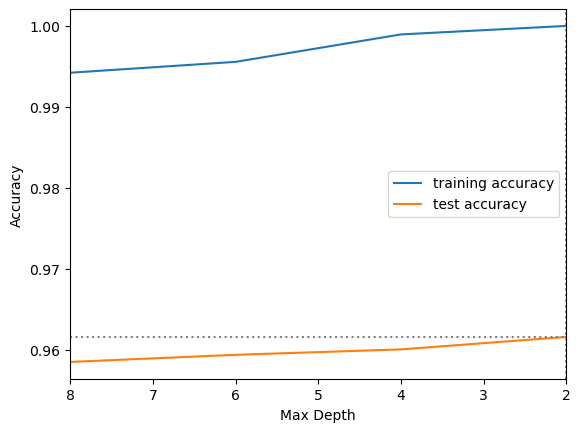

In [45]:
plt.plot(results_rf.param_min_samples_split, 
         results_rf.mean_train_score, 
         label="training accuracy")
plt.plot(results_rf.param_min_samples_split,
         results_rf.mean_test_score,
         label="test accuracy")
plt.axhline(max(results_rf.mean_test_score), linestyle='dotted', color='gray')
plt.axvline(results_rf['param_min_samples_split'].iloc[results_rf['mean_test_score'].idxmax()], 
            linestyle='dotted', color='gray')
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xlim((8, 2))
plt.legend();

We sometimes don't see the typical pattern in a validation curve graph for random forest, because random forest is designed to avoid overfitting. In addition, because of the randomization applied to the features and instances used for each tree it takes a lot of iterations to get a fair comparison between parameter values. That is why we did so many repeats of the stratified K-fold cross validation for the final grid search.

### Tree models keep track of feature importance

Feature importance is a measure of each feature's relative importance to the final prediction. These values may be useful for explaining the relative importance of the various features to stakeholders, or for feature selection for further modeling.

The code below fits a random forest model, with the best parameter setting identified by the final grid search, to the breast cancer data and then displays the feature importance values for each feature. The higher the feature importance value the more important that feature is to the final prediction. 

It is the `feature_importances_` property of the fitted random forest model that returns the feature importance numbers. The code below zips them together with the feature names so we can see which feature is associated with each of the feature importance values.

In [48]:
forest = RandomForestClassifier(**grid_search_rf_2.best_params_).fit(cancer.data, cancer.target)

list(zip(cancer.feature_names, forest.feature_importances_))

[('mean radius', 0.03135678961056076),
 ('mean texture', 0.015678830449372093),
 ('mean perimeter', 0.049082219124941824),
 ('mean area', 0.053633978100333324),
 ('mean smoothness', 0.008788527045686298),
 ('mean compactness', 0.004338096837094072),
 ('mean concavity', 0.029235313159226527),
 ('mean concave points', 0.09335489058463799),
 ('mean symmetry', 0.0045151352007339295),
 ('mean fractal dimension', 0.004037012419507418),
 ('radius error', 0.024317048878768458),
 ('texture error', 0.0032706265074594924),
 ('perimeter error', 0.008843796642619348),
 ('area error', 0.04005486403100197),
 ('smoothness error', 0.0036899919727558213),
 ('compactness error', 0.004123354380559759),
 ('concavity error', 0.00643464723230833),
 ('concave points error', 0.008563527760785006),
 ('symmetry error', 0.003917860672111447),
 ('fractal dimension error', 0.006285350353328055),
 ('worst radius', 0.09444204080119731),
 ('worst texture', 0.019228500524104082),
 ('worst perimeter', 0.0973502577034639

#### Plot the feature importances

We can also plot the feature importances to make it easier to interpret them quickly.

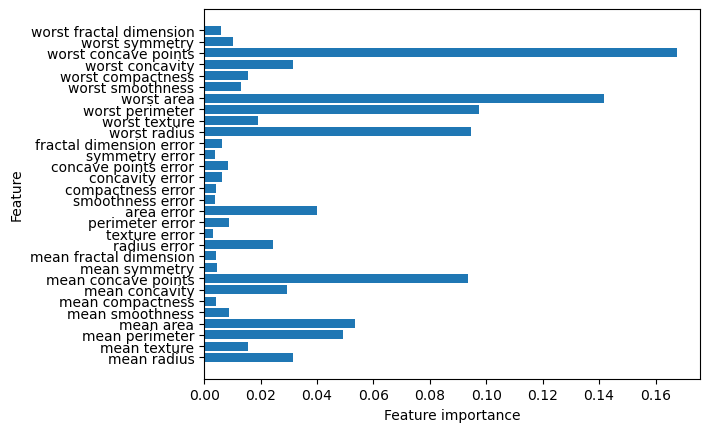

In [49]:
plt.barh(cancer.feature_names, forest.feature_importances_, align='center')
plt.xlabel("Feature importance")
plt.ylabel("Feature");